 ## Discretizando variables numéricas

Discretización es el proceso de transformar las variables numéricas en variables discretas creando un conjunto de intervalos o segmentos continuos que abarcan todo el rango de la variable transformada. Los segmentos también se conocen como bins o buckets, de ahí que al proceso de discretizar se le conozca como 'binning' en inglés.  Continuemos con los ejemplos.


### Discretización ayuda con el manejo de valores extremos y mejora la distribución de las variables sesgadas.

Discretización mitiga el efecto de los valores extremos colocándolos en los intervalos inferiores o superiores, junto con el resto de los valores cercanos en la distribución. Por lo tanto, estos valores extremos ya no son diferentes de los otros y hacen parte del mismo intervalo o bucket. Además, si los segmentos o bins son seleccionados apropiadamente, discretización puede ayudar a escalar las variables sesgadas en un conjunto de intervalos con una mejor distribución


### Criterios de segmentación/discretización

Hay varios métodos para transformar las variables continuas en variables discretas, y en general se pueden dividir en dos categorías: **supervisados y sin supervisión**. Los métodos sin supervisión no usan ninguna información aparte de la distribución de la variable para crear los segmentos continuos en los cuales los valores van a ser ubicados. Los métodos supervisados típicamente usan la información del target para construir los intervalos o bins.


####  Métodos de discretización sin supervisión (unsupervised en inglés)

Los criterios de segmentación más comunes son:

- Igual rango
- Igual frecuencia
- K-means

####  Métodos de discretización supervisados

- Usando árboles de decisión


En esta lección, vamos a estudiar la **discretización con igual frecuencia**.


## Discretización en intervalos de Igual Frecuencia

Esta técnica agrupa la misma cantidad de observaciones utilizando criterios basados en cuantiles; el rango de los posibles valores de una variable se divide en N segmentos y  cada segmento tiene el mismo número de observaciones.

Esta técnica es particularmente útil para variables con distribuciones sesgadas ya que propaga las observaciones en todos los segmentos equitativamente. Los límites de cada intervalo se determinan utilizando los cuantiles.

La discretización por intervalos de igual frecuencia,  usando cuantiles, consiste en dividir una variable continua en N cuantiles, donde N se define por el usuario.

La discretización por igual frecuencia es simple de implementar y al distribuir los valores de las observaciones más equitativamente puede ayudar a aumentar el desempeño del algoritmo. Esta discretización arbitraria puede alterar la relación con el target. 


## En este demo

Vamos a aprender como discretizar variables utilizando el método de igual rango usando los datos del Titanic

- pandas y NumPy
- Feature-engine
- Scikit-learn




## Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisation import EqualFrequencyDiscretiser

In [2]:
# cargar variables numéricas Titanic Dataset

data = pd.read_csv('../titanic.csv',
                   usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# separemos sets entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

Las variables age y fare contienen datos faltantes. Los vamos a completar extrayendo una muestra aleatoria de la variable.

In [4]:
def impute_na(data, variable):
    
    # función para reemplazar NA con una muestra aleatoria

    df = data.copy()

    # muestra aleatoria
    df[variable+'_aleatoria'] = df[variable]

     # extraer muestra aleatoria para completar datos faltantes na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas necesita tener el mismo index para poder 
    # combinar los dataframes
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_aleatoria'] = random_sample

    return df[variable+'_aleatoria']

In [5]:
# reemplazar los NA en sets de entrenamiento y prueba

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

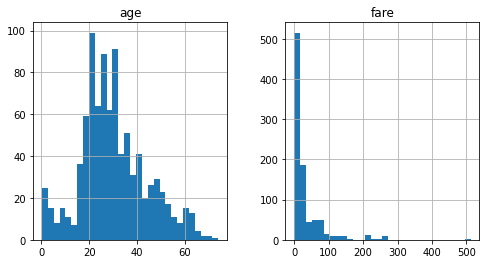

In [6]:
# exploremos la distribución de la variable age

X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Discretización Igual frecuencia con pandas y NumPy

El límite de los intervalos son los límites de los cuantiles. Podemos encontrarlos con con pandas qcut.

In [7]:
# usemos pandas qcut (quantile cut) e indiquemos el número de bins deseado

# retbins = True indica que queremos capturar los límites
# de cada intervalo (para luego usarlos en el set the prueba)

age_discretizada, intervals = pd.qcut(
    X_train['age'], 10, labels=None, retbins=True, precision=3, duplicates='raise')

pd.concat([age_discretizada, X_train['age']], axis=1).head(10)

,age,age
501,"(0.166, 16.0]",13.0
588,"(0.166, 16.0]",4.0
402,"(28.0, 31.0]",30.0
1193,"(20.0, 22.25]",21.0
686,"(20.0, 22.25]",22.0
971,"(0.166, 16.0]",16.0
117,"(28.0, 31.0]",30.0
540,"(0.166, 16.0]",2.0
294,"(42.0, 50.0]",49.0
261,"(31.0, 36.0]",35.0


Podemos ver que en el resultado anterior que al discretizar usando cuantiles, colocamos cada observación en la variable age en un intervalo.
Por ejemplo, el valor 29 fué colocado en el intervalo 26-30, mientras que el valor 63 fue colocado en el intervalo 49-80. 

Date cuenta cómo el rango de los intervalos es diferente.

Podemos visualizar los límites de cada intervalo así:

In [8]:
intervals

array([ 0.1667, 16.    , 20.    , 22.25  , 25.    , 28.    , 31.    ,
       36.    , 42.    , 50.    , 74.    ])

ya que generamos los intervalos usando el método los cuantiles, tenemos más o menos el mismo número de observaciones por intervalo. Veamos a continuación:

In [9]:
# más o menos el mismo número de observaciones por intervalo

age_discretizada.value_counts()

(31.0, 36.0]     106
(0.166, 16.0]    103
(25.0, 28.0]      95
(22.25, 25.0]     94
(42.0, 50.0]      92
(16.0, 20.0]      91
(28.0, 31.0]      91
(36.0, 42.0]      84
(20.0, 22.25]     81
(50.0, 74.0]      79
Name: age, dtype: int64

In [10]:
# podemos añadir etiquetas en lugar de tener los límites de los intervalos:

labels = ['Q'+str(i) for i in range(1,11)]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [11]:
age_discretizada, intervals = pd.qcut(X_train['age'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='raise')

age_discretizada.head()

501     Q1
588     Q1
402     Q6
1193    Q3
686     Q3
Name: age, dtype: category
Categories (10, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' ... 'Q7' < 'Q8' < 'Q9' < 'Q10']

In [12]:
# para transformar el set de prueba:
# usamos el método cut de pandas (en lugar de qcut) y
# pasamos los límites de los cuantiles calculados en el
# set de entrenamiento 

X_test['age_disc_etiqueta'] = pd.cut(x = X_test['age'], bins=intervals, labels=labels)
X_test['age_disc'] = pd.cut(x = X_test['age'], bins=intervals)

X_test.head(10)

,age,fare,age_disc_etiqueta,age_disc
1139,38.0,7.8958,Q8,"(36.0, 42.0]"
533,21.0,21.0000,Q3,"(20.0, 22.25]"
459,42.0,27.0000,Q8,"(36.0, 42.0]"
1150,34.0,14.5000,Q7,"(31.0, 36.0]"
393,25.0,31.5000,Q4,"(22.25, 25.0]"
1189,4.0,16.7000,Q1,"(0.167, 16.0]"
5,48.0,26.5500,Q9,"(42.0, 50.0]"
231,52.0,30.5000,Q10,"(50.0, 74.0]"
330,57.0,13.0000,Q10,"(50.0, 74.0]"
887,32.0,8.1125,Q7,"(31.0, 36.0]"


<AxesSubplot:xlabel='age_disc'>

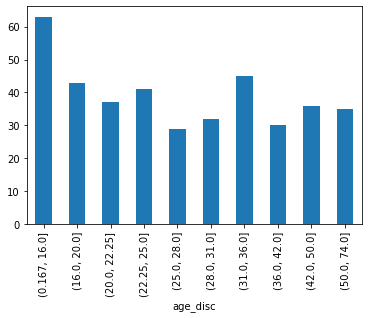

In [13]:
# revisemos que tenemos la misma frecuencia por intervalor (mismo número de observaciones)
X_test.groupby('age_disc')['age'].count().plot.bar()

Podemos ver que los intervalos superiores tienen menos observaciones. Esto puede pasar con distribuciones sesgadas si tratamos de dividirla en un alto número de intervalos. Para hacer los valores de la distribución mas homogéneos, debemos discretizar utilizando menos intervalos.

## Discretización Igual frecuencia utilizando Feature-engine

In [14]:
# separemos en sets de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [15]:
# reemplacemos los na en ambos segmentos

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [16]:
# con feature-engine podemos automatizar el proceso de discretización 
# para muchas variables en una línea de código

disc = EqualFrequencyDiscretiser(q=10, variables = ['age', 'fare'])

disc.fit(X_train)

EqualFrequencyDiscretiser(variables=['age', 'fare'])

In [17]:
# en el diccionario del binner, podemos ver los límites de los intervalos.
# Cada intervalo tiene un tamaño diferente

disc.binner_dict_

{'age': [-inf,
  16.0,
  20.0,
  22.25000000000003,
  25.0,
  28.0,
  31.0,
  36.0,
  42.0,
  50.0,
  inf],
 'fare': [-inf,
  7.55,
  7.7958,
  8.05,
  10.5,
  14.4542,
  21.075,
  26.55,
  40.125,
  79.025,
  inf]}

In [18]:
# transformar sets de entrenamiento y prueba
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [19]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,2,1
686,2,1


Text(0, 0.5, 'Proporción de observaciones por intervalo')

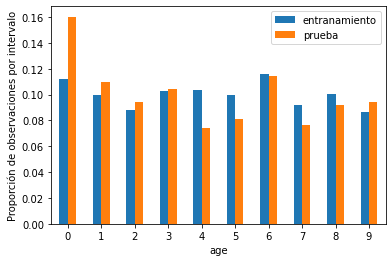

In [20]:
# y ahora exploramos el número de observaciones por intervalos

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entranamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Proporción de observaciones por intervalo')

Text(0, 0.5, 'Proporción de observaciones por intervalo')

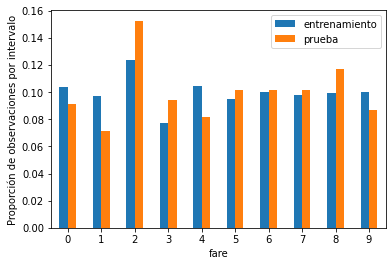

In [21]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Proporción de observaciones por intervalo')

Fíjate como la discretización por igual frecuencia mejora la distribución de los valores en cada uno de los intervalos para todos los valores en nuestra variable

## Discretización Igual frecuencia utilizando Scikit-learn

In [22]:
# separemos datos en sets de entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [23]:
# reemplacemos los na en ambos segmentos

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [24]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [25]:
disc.bin_edges_

array([array([ 0.1667, 16.    , 20.    , 22.25  , 25.    , 28.    , 31.    ,
              36.    , 42.    , 50.    , 74.    ])                          ,
       array([  0.    ,   7.55  ,   7.7958,   8.05  ,  10.5   ,  14.4542,
               21.075 ,  26.55  ,  40.125 ,  79.025 , 512.3292])         ],
      dtype=object)

In [26]:
train_t = disc.transform(X_train[['age', 'fare']])

train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])

train_t.head()

,age,fare
0,0.0,5.0
1,0.0,6.0
2,5.0,4.0
3,2.0,1.0
4,2.0,1.0


In [27]:
test_t = disc.transform(X_test[['age', 'fare']])

test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])

Text(0, 0.5, 'Proporción de observaciones por intervalo')

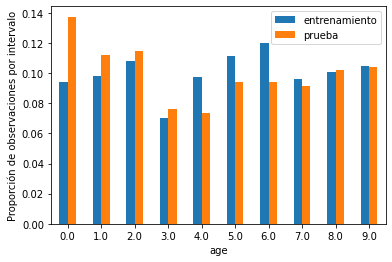

In [28]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Proporción de observaciones por intervalo')

Text(0, 0.5, 'Proporción de observaciones por intervalo')

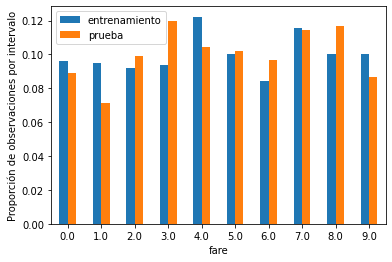

In [29]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Proporción de observaciones por intervalo')